In [1]:
import os
import ray
import random
import datetime

import numpy as np

import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

from util import *
from estimator import *
from evaluator import run_grid_search

os.environ.pop('http_proxy', None)

/Users/jonas/Documents/GitHub/Reproducibility-sens-cons/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jonas/Documents/GitHub/Reproducibility-sens-cons/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-15 13:29:11,306	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


### Parse RTE data

In [4]:
input_file = Path('./data/RTE/train.jsonl')
results_folder = Path('./data/RTE_RESULTS')
processed_data_file = Path('./data/RTE_RESULTS/data.json')
dataset = 'RTE'
class_labels = ["entailment", "contradiction/neutral", "N/A"]
class_labels_to_id = {c_name: i for i, c_name in enumerate(class_labels)}

def parse_CB(input_file):
    
    data_list = []

    # Open the JSONL file and read line by line
    with open(input_file, 'r') as file:
        for line in file:
            # Parse JSON from each line
            json_obj = json.loads(line)

            # Extract relevant fields from the JSON object
            idx = json_obj['idx']
            premise = json_obj['premise']
            hypothesis = json_obj['hypothesis']
            label = json_obj['label']

            if label == 'not_entailment':
                label = 'contradiction/neutral'
            
            # Prepare the input string as specified
            input_text = f"Premise: {premise}\nHypothesis: {hypothesis}"

            # Create a new dictionary in the desired format
            new_entry = {
                "id": idx,
                "input": input_text,
                "class": label
            }

            # Append the new dictionary to the data list
            data_list.append(new_entry)

    return data_list


if not os.path.exists(processed_data_file):
    data_list = parse_CB(input_file)  # do not count NA

    # Serialize the dictionary to a JSON string
    json_data = json.dumps(data_list)

    # Write the JSON string to a file
    with open(processed_data_file, 'w') as f:
        f.write(json_data)
else:
    with open(processed_data_file, 'r') as f:
        data_list = json.load(f)


n_samples = len(data_list)
sample_ids = [s["id"] for s in data_list]

def class_extractor_fun(text):
    # we might want to check if more than a word is returned, but does not seem strictly necessary
    for l in class_labels:
        if l.lower() in text.lower():
            return l
    # if no label has been found
    return "N/A"

In [5]:
len(data_list)
# s_id = 1
# print(data_list[s_id]['input'])
# print(data_list[s_id]['class'])

2490

## Run a grid search over parameters

In [6]:
question_to_rewrite = "You are given a premise and a hypothesis as input. Determine is there is entailment or a contradiction/neutral statement."

prompt_simple = [
    ["system", "You are a text entailment system."],
    ["user", "You are given a premise and a hypothesis as input. You are given a premise and a hypothesis as input. Determine is there is entailment or a contradiction/neutral statement.\nAnswer with the class name only.\nThe possible classes are: entailment and contradiction/neutral.\nHere is the text: {summary}"]    
]

prompt_instruct = [
    ["system", "You are a text entailment system."],
    ["user", "You are given a premise and a hypothesis as input. You are given a premise and a hypothesis as input. Determine is there is entailment or a contradiction/neutral statement.\nAnswer with the class name only.\nThe possible classes are: \n- entailment: a logical relationship where the meaning of one text (the hypothesis) is necessarily implied by another text (the premise), \n- contradiction/neutral: contradictions or neutral statements that are not entailments\n\nHere is the text: {summary}"]    
]


prompt_fewshot = [
    ["system", "You are a text entailment system."],
    ["user",
     "You are given a premise and a hypothesis as input. Determine is there is entailment or a contradiction/neutral statement.\nAnswer with the class name only.\nThe possible classes are: entailment and contradiction/neutral.\n"
     "Here are a few examples:\n"
     "Example 1:\n"
     "Premise: Dana Reeve, the widow of the actor Christopher Reeve, has died of lung cancer at age 44, according to the Christopher Reeve Foundation. Hypothesis:\n Christopher Reeve had an accident. Label: contradiction/neutral\n"
     "Example 2:\n"
     "Premise: And I don't want to have to lie to them. The kidnappers have given us until October the eleventh to deliver the document and I haven't despaired of finding it before then. But if the police learn I 've been to America they 'll ask why. Hypothesis:\n he's been to America. Label: entailment\n"
     "Here is the text: {summary}"]
]


prompt_types = {"simple": prompt_simple,
               "instruct": prompt_instruct,
               "fewshot": prompt_fewshot}

llms = ['mixtral']#, 'gpt-3.5', 'gpt-4o']
Qs = [30] # number of equivalent but alternative questions compared to original question
temp_questions = [0.]#list(np.arange(0., 1.25, 0.25))  # temperature of the LLM used to produce questions
As = [1] # number of alternative answers for each questions
temp_answers =  [0.] # list(np.arange(0., 1.5, 0.25))  # temperature of the LLM used to produce answers

samples = data_list
n_samples = len(samples)
print(f'Num test examples is {len(samples)}')

Num test examples is 2490


Prompt type: simple


KeyboardInterrupt: 

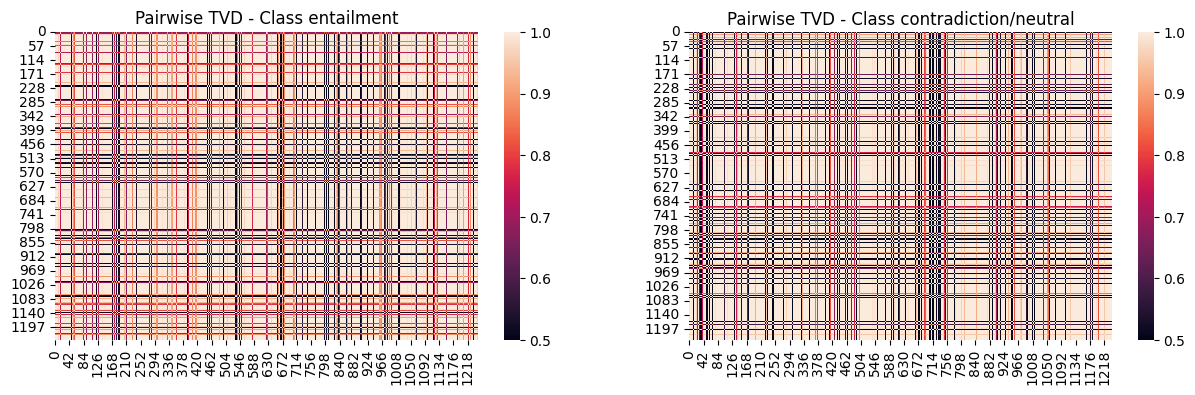

In [7]:
plot_TVD_info(sample_ids,
              prompt_types,
              llms,
              Qs,
              temp_questions,
              As,
              temp_answers,
              class_labels,
              results_folder)

Prompt type: simple


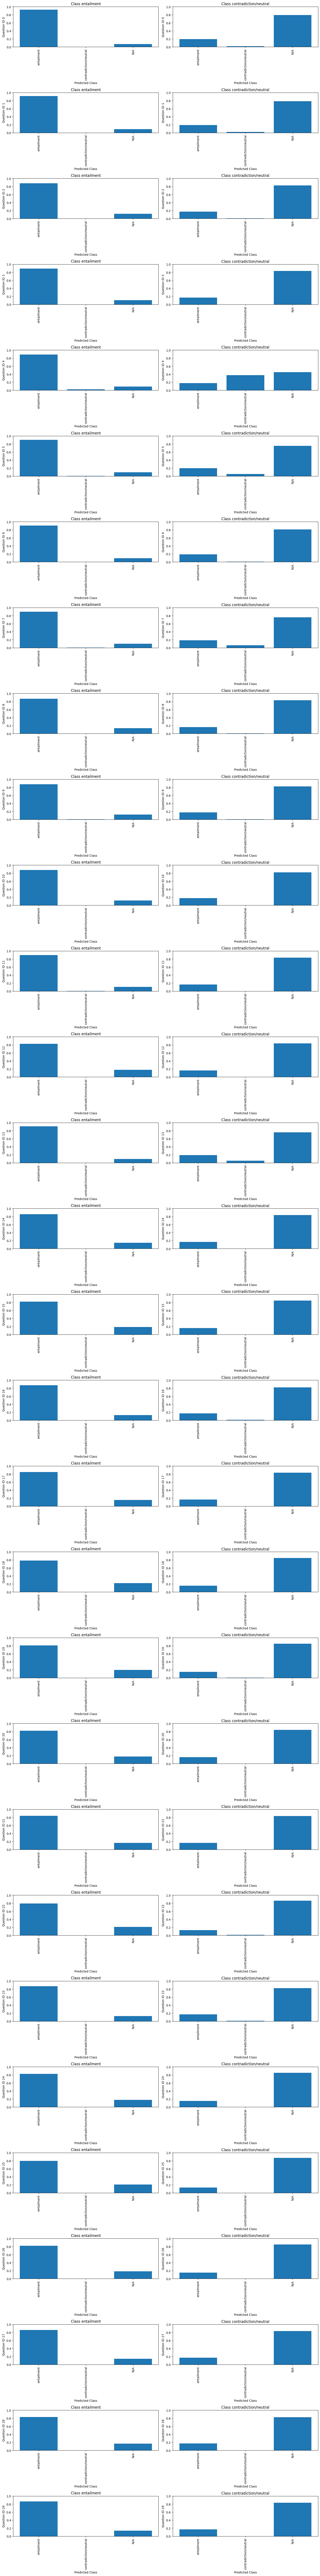

Prompt type: instruct


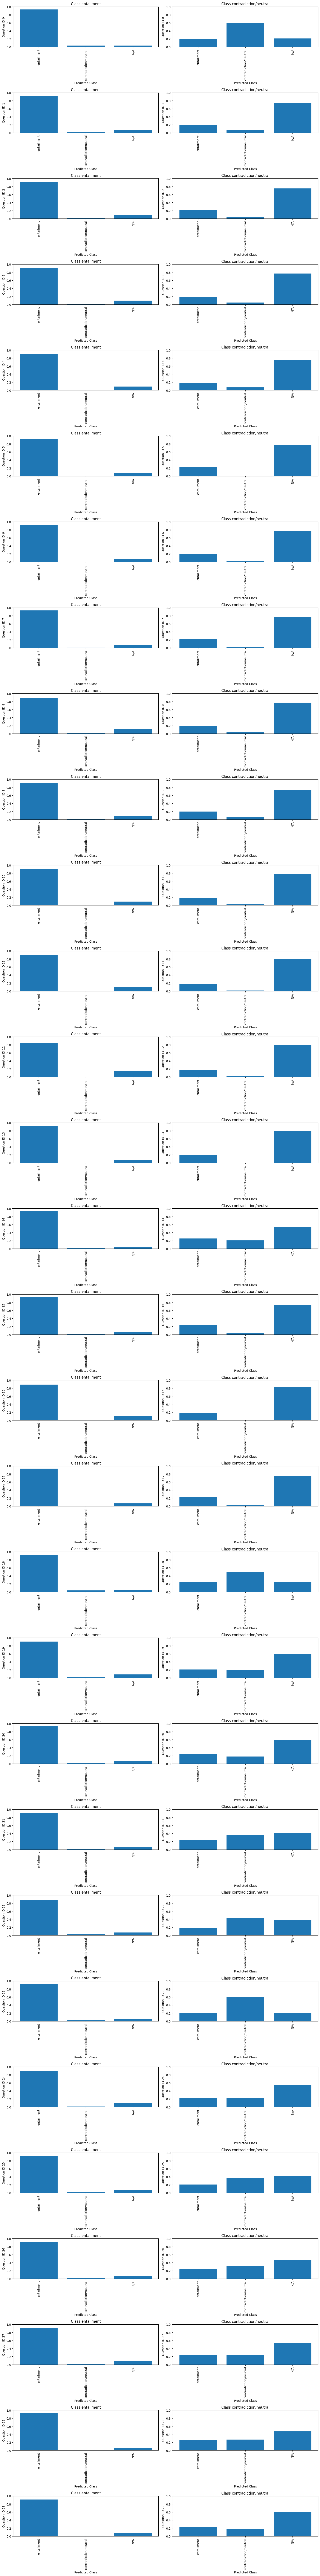

Prompt type: fewshot


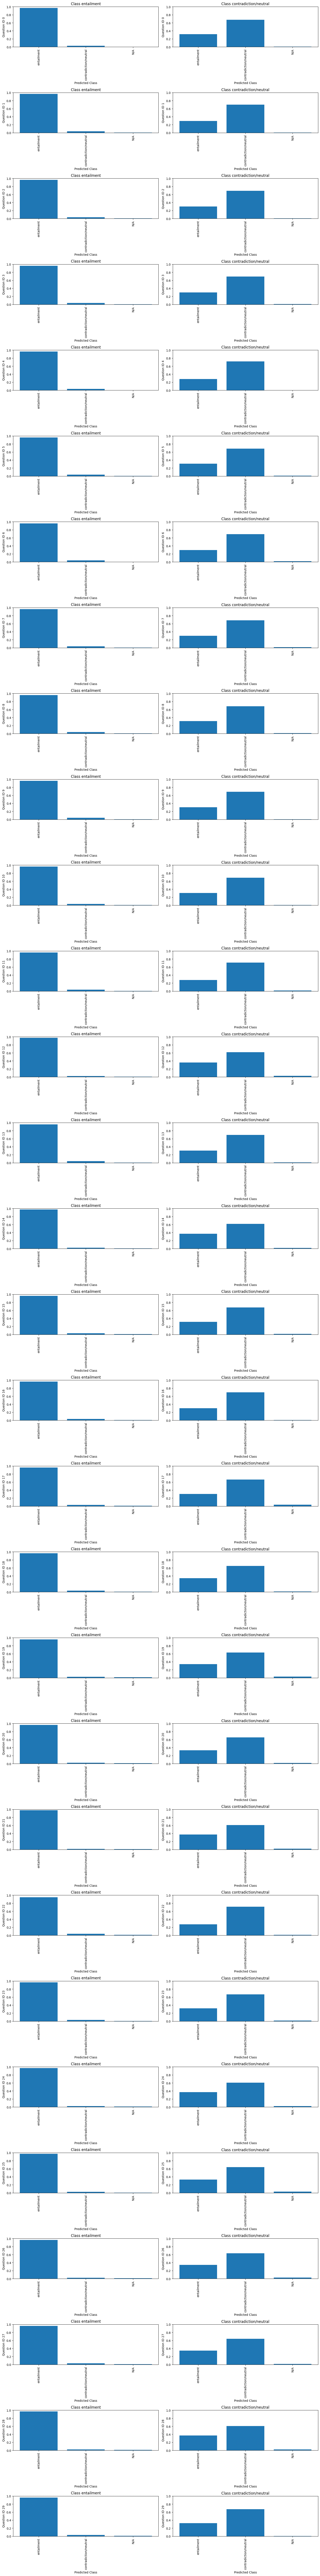

In [8]:
plot_questions_vs_predicted_distribution(sample_ids,
                                        prompt_types,
                                        llms,
                                        Qs,
                                        temp_questions,
                                        As,
                                        temp_answers,
                                        class_labels,
                                        results_folder)

Prompt type: simple


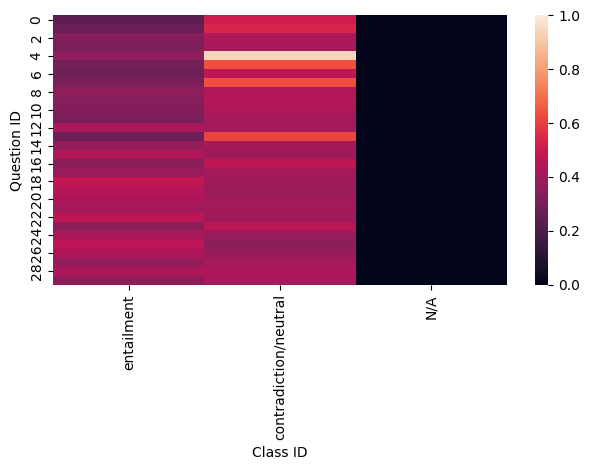

Prompt type: instruct


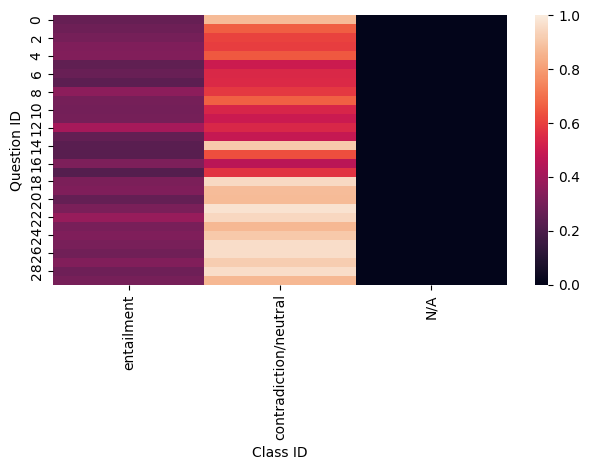

Prompt type: fewshot


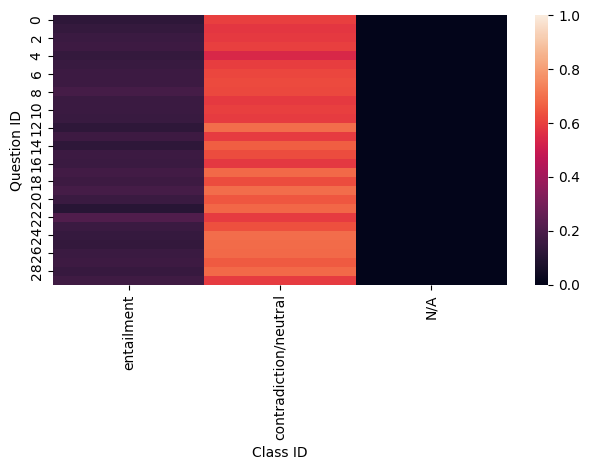

In [8]:
plot_questions_vs_class_sensitivity(sample_ids,
                               prompt_types,
                               llms,
                               Qs,
                               temp_questions,
                               As,
                               temp_answers,
                               class_labels,
                               results_folder)

In [9]:
for llm in ['mixtral']:
    for prompt_type in ['simple', 'instruct', 'fewshot']:
        print(llm, prompt_type)
        Q = 30
        A = 1  # MUST stay 1
        temp_question = 0.
        temp_answer = 0.
        max_value = 1
        
        print_classification_scores(sample_ids,
                                    prompt_type,
                                    llm,
                                    Q,
                                    temp_question,
                                    A,
                                    temp_answer,
                                    class_labels,
                                    results_folder)

mixtral simple


NameError: name 'accuracy_score' is not defined

mixtral simple
Avg Entropy over samples: 0.1063031678108772,Std over samples: 0.17486114664249786
mixtral instruct
Avg Entropy over samples: 0.2529052757392989,Std over samples: 0.2773619444164554
mixtral fewshot
Avg Entropy over samples: 0.08697441609900033,Std over samples: 0.19112293587605714


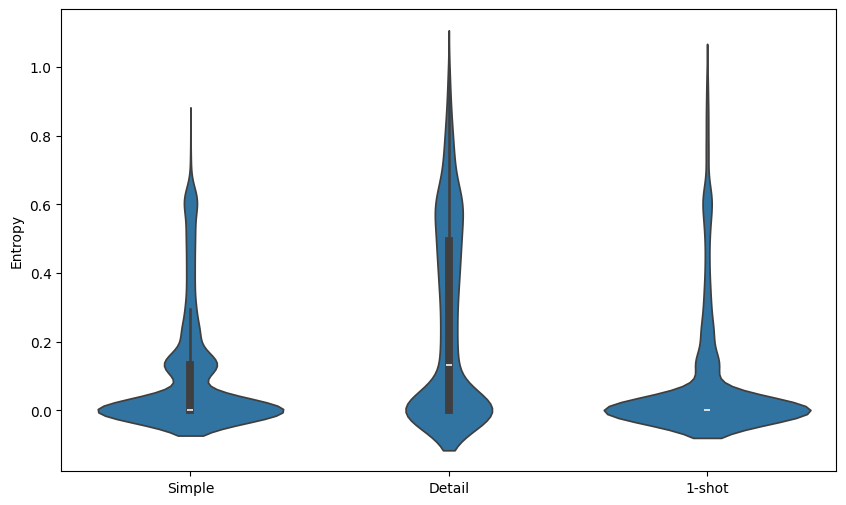

In [11]:
for llm in ['mixtral']:
    Q = 30
    A = 1  # MUST stay 1
    temp_question = 0.
    temp_answer = 0.
    
    data = []
    
    for prompt_type in ['simple', 'instruct', 'fewshot']:
        print(llm, prompt_type)
        em = print_test_sensitivity_over_samples(sample_ids,
                                        prompt_type,
                                        llm,
                                        Q,
                                        temp_question,
                                        A,
                                        temp_answer,
                                        class_labels,
                                        results_folder)
    
        data.append((em, prompt_type))
    
    # Prepare lists to collect expanded data
    expanded_values = []
    expanded_labels = []
    
    # Expand the data into individual points
    for arr, label in data:
        expanded_values.extend(arr)
        expanded_labels.extend([label] * len(arr))
    
    # Create a DataFrame from the expanded data
    df = pd.DataFrame({'Values': expanded_values, 'Label': expanded_labels})
    
    # Plot the violin plot
    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
    ax =sns.violinplot(x='Label', y='Values', data=df, split=False)
    plt.xlabel(None)
    ax.set_xticks(np.arange(3)) # <--- set the ticks first
    ax.set_xticklabels(['Simple', 'Detail', '1-shot'])
    plt.ylabel('Entropy')
    plt.show()

In [12]:
if not os.path.exists(Path(results_folder, 'paper_figures')):
    os.makedirs(Path(results_folder, 'paper_figures'))
    
# Configure matplotlib to use LaTeX
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# Set the global font size
plt.rc('font', size=20)  # Example: set the font size to 14

sns.set_style("whitegrid")
sns.color_palette("colorblind")

dataset="RTE"

figsize=(7.5,4.5)
n_samples, n_classes = len(samples), len(class_labels)

for llm in ['mixtral']:
    Q = 30
    A = 1  # MUST stay 1
    temp_question = 0.
    temp_answer = 0.
    
    data = []

    for prompt_type in ['simple', 'instruct', 'fewshot']:
        print(llm, prompt_type)
        TVD_matrix_per_class = print_consistency(sample_ids,
                                       prompt_type,
                                       llm,
                                       Q,
                                       temp_question,
                                       A,
                                       temp_answer,
                                       class_labels,
                                       results_folder)
    
        for c, TVD_matrix in enumerate(TVD_matrix_per_class):
            data.append((TVD_matrix.reshape(-1), prompt_type))
            
            c_name = class_labels[c]

            # plt.figure(figsize=(figsize[0]+1, figsize[0]))
            # ax = sns.heatmap(TVD_matrix, cbar_kws={'orientation': 'horizontal'})
            # plt.xlabel("Sample ID",fontsize=26)
            # plt.ylabel("Sample ID",fontsize=26)
            # Adjust the layout to make room for the colorbar
            # plt.tight_layout()
            # plt.savefig(Path(results_folder, 'paper_figures', f'TVD_matrix_{dataset}_{prompt_type}_{llm}_{Q}_{A}_{temp_question}_{temp_answer}_{c_name}.pdf'))
            #plt.show()

            # sns.histplot(np.reshape(TVD_matrix, -1),
            #                         bins=20, stat='probability', kde=False, color='#3274A1', alpha=1.)
            # plt.xlabel(r"$C_y(x,x')$")
            # plt.tight_layout()
            # plt.savefig(Path(results_folder, 'paper_figures', f'TVD_hist_{dataset}_{prompt_type}_{llm}_{Q}_{A}_{temp_question}_{temp_answer}_{c_name}.pdf'))
            #plt.show()
    
    
    # Prepare lists to collect expanded data
    expanded_values = []
    expanded_labels = []
    
    # Expand the data into individual points
    for arr, label in data:
        expanded_values.extend(arr)
        expanded_labels.extend([label] * len(arr))
    
    # Create a DataFrame from the expanded data
    df = pd.DataFrame({'Values': expanded_values, 'Label': expanded_labels})
    
    # Plot the violin plot
    # plt.figure(figsize=figsize)  # Adjust the figure size if needed
    # ax = sns.violinplot(x='Label', y='Values', data=df, split=False)
    # plt.xlabel(None)
    # ax.set_xticks(np.arange(3)) # <--- set the ticks first
    # ax.set_xticklabels(['Simple', 'Detail', '1-shot'])
    # plt.ylim(0, 1)
    # plt.ylabel('Consistency')
    # plt.tight_layout()
    # plt.savefig(Path(results_folder, 'paper_figures',
    #         f'consistency_vs_prompting_{dataset}_{llm}_{Q}_{A}_{temp_question}_{temp_answer}.pdf'))
    # plt.show()

mixtral simple
Prompt type: simple
Avg consistency: 0.7328427871692857,Std consistency: 0.376190971129763
mixtral instruct
Prompt type: instruct
Avg consistency: 0.7116352191114083,Std consistency: 0.35327927045568785
mixtral fewshot
Prompt type: fewshot
Avg consistency: 0.7461184360069624,Std consistency: 0.3806151390159792


mixtral simple
Avg Entropy over samples: 0.1063031678108772,Std over samples: 0.17486114664249786


/var/folders/jt/xr8rl11x57b589mn71s3hrcm0000gp/T/ipykernel_10255/3887853715.py:54: RuntimeWarning: Mean of empty slice.
  sens_per_class_mean = np.array([np.array(sens_per_class[c]).mean() for c in range(len(class_labels))])
/Users/jonas/Documents/GitHub/Reproducibility-sens-cons/.venv/lib/python3.9/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jonas/Documents/GitHub/Reproducibility-sens-cons/.venv/lib/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jonas/Documents/GitHub/Reproducibility-sens-cons/.venv/lib/python3.9/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jonas/Documents/GitHub/Reproducibility-sens-cons/.venv/lib/python3.9/site-packages/numpy/_core/_met

mixtral instruct
Avg Entropy over samples: 0.2529052757392989,Std over samples: 0.2773619444164554


/var/folders/jt/xr8rl11x57b589mn71s3hrcm0000gp/T/ipykernel_10255/3887853715.py:54: RuntimeWarning: Mean of empty slice.
  sens_per_class_mean = np.array([np.array(sens_per_class[c]).mean() for c in range(len(class_labels))])
/Users/jonas/Documents/GitHub/Reproducibility-sens-cons/.venv/lib/python3.9/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jonas/Documents/GitHub/Reproducibility-sens-cons/.venv/lib/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jonas/Documents/GitHub/Reproducibility-sens-cons/.venv/lib/python3.9/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jonas/Documents/GitHub/Reproducibility-sens-cons/.venv/lib/python3.9/site-packages/numpy/_core/_met

mixtral fewshot
Avg Entropy over samples: 0.08697441609900033,Std over samples: 0.19112293587605714


/var/folders/jt/xr8rl11x57b589mn71s3hrcm0000gp/T/ipykernel_10255/3887853715.py:54: RuntimeWarning: Mean of empty slice.
  sens_per_class_mean = np.array([np.array(sens_per_class[c]).mean() for c in range(len(class_labels))])
/Users/jonas/Documents/GitHub/Reproducibility-sens-cons/.venv/lib/python3.9/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jonas/Documents/GitHub/Reproducibility-sens-cons/.venv/lib/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jonas/Documents/GitHub/Reproducibility-sens-cons/.venv/lib/python3.9/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/jonas/Documents/GitHub/Reproducibility-sens-cons/.venv/lib/python3.9/site-packages/numpy/_core/_met

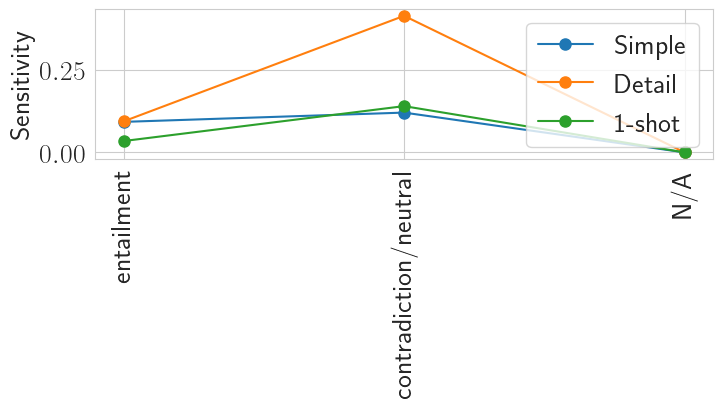

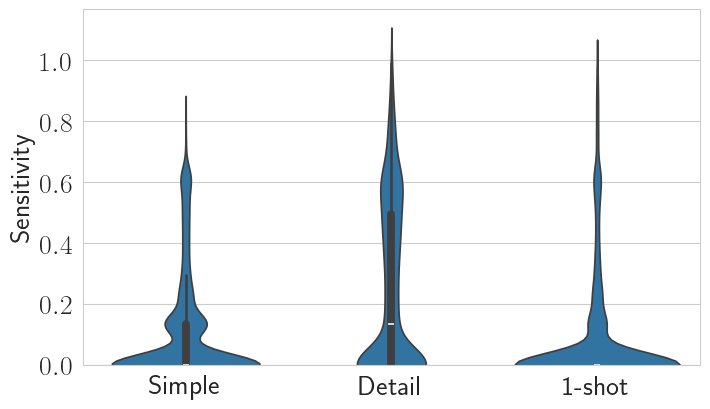

In [13]:
# Configure matplotlib to use LaTeX
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# Set the global font size
plt.rc('font', size=20)  # Example: set the font size to 14

sns.set_style("whitegrid")
sns.color_palette("colorblind")

figsize=(7.5,4.5)

for llm in ['mixtral']:
    Q = 30
    A = 1  # MUST stay 1
    temp_question = 0.
    temp_answer = 0.
    
    data = []

    errorbar_fig = plt.figure(figsize=figsize)

    
    for prompt_type in ['simple', 'instruct', 'fewshot']:
        print(llm, prompt_type)
        em = print_test_sensitivity_over_samples(sample_ids,
                                        prompt_type,
                                        llm,
                                        Q,
                                        temp_question,
                                        A,
                                        temp_answer,
                                        class_labels,
                                        results_folder)

        sens_per_class = sensitivity_per_class(sample_ids,
                                               prompt_type,
                                               llm,
                                               Q,
                                               temp_question,
                                               A,
                                               temp_answer,
                                               class_labels,
                                               results_folder)

        # Add error bars (standard deviation)
        plt.figure(errorbar_fig)
        if prompt_type == 'instruct':
            label = 'Detail'
        elif prompt_type == 'fewshot':
            label = '1-shot'
        else:
            label = 'Simple'

        sens_per_class_mean = np.array([np.array(sens_per_class[c]).mean() for c in range(len(class_labels))])
        sens_per_class_mean = np.nan_to_num(sens_per_class_mean)
        sens_per_class_std = np.array([np.array(sens_per_class[c]).std() for c in range(len(class_labels))])
        sens_per_class_std = np.nan_to_num(sens_per_class_std)
        # plt.errorbar(np.arange(len(class_labels)), sens_per_class_mean, yerr=sens_per_class_std, fmt='-o',  solid_capstyle='projecting', capsize=5, label=label)
        plt.plot(sens_per_class_mean, label=label, marker='o', markersize=8)
        plt.ylabel('Sensitivity')
        plt.xticks(np.arange(len(class_labels)),
                            class_labels,
                            rotation='vertical')      
        plt.legend()
        
        data.append((em, prompt_type))

        plt.figure(errorbar_fig)
    plt.tight_layout()
    plt.savefig(Path(results_folder, 'paper_figures',
                f'sensitivity_vs_class_{dataset}_{llm}_{Q}_{A}_{temp_question}_{temp_answer}.pdf'))
    
    
    # Prepare lists to collect expanded data
    expanded_values = []
    expanded_labels = []
    
    # Expand the data into individual points
    for arr, label in data:
        expanded_values.extend(arr)
        expanded_labels.extend([label] * len(arr))
    
    # Create a DataFrame from the expanded data
    df = pd.DataFrame({'Values': expanded_values, 'Label': expanded_labels})
    
    # Plot the violin plot
    plt.figure(figsize=figsize)  # Adjust the figure size if needed
    ax = sns.violinplot(x='Label', y='Values', data=df, split=False)
    ax.set_xticklabels(['Simple', 'Detail', '1-shot'])
    plt.xlabel(None)
    plt.ylabel('Sensitivity')
    # Setting the y-axis limits to cut off values below 0
    plt.ylim(0, None)
    plt.tight_layout()
    plt.savefig(Path(results_folder, 'paper_figures',
                f'sensitivity_vs_prompting_{dataset}_{llm}_{Q}_{A}_{temp_question}_{temp_answer}.pdf'))
    plt.show()

mixtral simple
Avg Entropy over samples: 0.1063031678108772,Std over samples: 0.17486114664249786
mixtral instruct
Avg Entropy over samples: 0.2529052757392989,Std over samples: 0.2773619444164554
mixtral fewshot
Avg Entropy over samples: 0.08697441609900033,Std over samples: 0.19112293587605714
   Sensitivity Strategy      LLM  Temperature
0     0.106303   Simple  mixtral            0
1     0.252905   Detail  mixtral            0
2     0.086974   1-shot  mixtral            0


<Figure size 750x450 with 0 Axes>

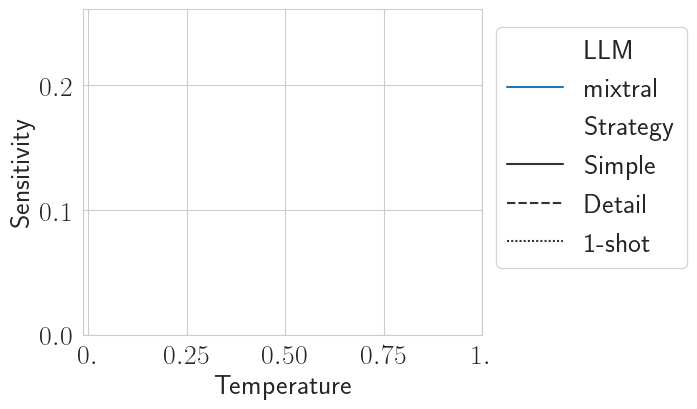

In [14]:
# Configure matplotlib to use LaTeX
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# Set the global font size
plt.rc('font', size=20)  # Example: set the font size to 14

sns.set_style("whitegrid")
sns.color_palette("colorblind")

figsize=(7.5,4.5)

Q = 30
A = 1  # MUST stay 1
temp_answer = 0.


data = []
errorbar_fig = plt.figure(figsize=figsize)
    
for temp_question in temp_questions:
    
    for llm in ['mixtral']:
        
        for prompt_type in ['simple', 'instruct', 'fewshot']:
            print(llm, prompt_type)
            em = print_test_sensitivity_over_samples(sample_ids,
                                            prompt_type,
                                            llm,
                                            Q,
                                            temp_question,
                                            A,
                                            temp_answer,
                                            class_labels,
                                            results_folder)
    
    
            # Add error bars (standard deviation)
            plt.figure(errorbar_fig)
            if prompt_type == 'instruct':
                label = 'Detail'
            elif prompt_type == 'fewshot':
                label = '1-shot'
            else:
                label = 'Simple'
    
            
            data.append((em.mean(), label, llm, int(temp_question/0.25)))
            
        
        
# Create a DataFrame from the expanded data
df = pd.DataFrame(data, columns=['Sensitivity', 'Strategy', 'LLM', 'Temperature'])
print(df)
# Plot the violin plot
plt.figure(figsize=figsize)  # Adjust the figure size if needed
ax = sns.lineplot(x='Temperature', y='Sensitivity', hue='LLM', style='Strategy', data=df)
ax.set_xticks(np.arange(5)) # <--- set the ticks first
ax.set_xticklabels([r'$0.$', r'$0.25$', r'$0.50$', r'$0.75$', r'$1.$'])
# Setting the y-axis limits to cut off values below 0
plt.ylim(0, None)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.575))
plt.tight_layout()
plt.savefig(Path(results_folder, 'paper_figures',
            f'sensitivity_vs_temperature_{dataset}_{Q}_{A}_{temp_answer}.pdf'))
plt.show()